In [1]:
import numpy as np
import pandas as pd
import mikeio
from mikeio import ItemInfo, EUMType, EUMUnit


# Write a dfs0

A mikeio.Dataset contains the information needed to write a dfs file. A Dataset consists of one or more mikeio.DataArrays each corresponding to an "item" in a dfs file.

In [2]:
nt = 10
time = pd.date_range("2000-1-1", periods=nt, freq='H')

d1 = np.zeros(nt)
item = ItemInfo("Zeros", EUMType.Water_Level)
da1 = mikeio.DataArray(d1, time=time, item=item)

d2 = np.ones(nt)
item = ItemInfo("Ones", EUMType.Discharge, EUMUnit.meter_pow_3_per_sec)
da2 = mikeio.DataArray(d2, time=time, item=item)

ds = mikeio.Dataset([da1, da2])
ds

<mikeio.Dataset>
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
geometry: GeometryUndefined()
items:
  0:  Zeros <Water Level> (meter)
  1:  Ones <Discharge> (meter pow 3 per sec)

In [3]:
ds.is_equidistant

True

In [4]:
ds.to_dfs("test.dfs0", title="Zeros and ones")

# Read a timeseries

A dfs file is easily read with mikeio.read which returns a Dataset.

In [5]:
ds = mikeio.read("test.dfs0")
ds

<mikeio.Dataset>
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
geometry: GeometryUndefined()
items:
  0:  Zeros <Water Level> (meter)
  1:  Ones <Discharge> (meter pow 3 per sec)

## From comma separated file

In [6]:
df = pd.read_csv("../tests/testdata/co2-mm-mlo.csv", parse_dates=True, index_col='Date', na_values=-99.99)
df.head()

,Decimal Date,Average,Interpolated,Trend,Number of Days
Date,,,,,
1958-03-01,1958.208,315.71,315.71,314.62,-1
1958-04-01,1958.292,317.45,317.45,315.29,-1
1958-05-01,1958.375,317.50,317.50,314.71,-1
1958-06-01,1958.458,NaN,317.10,314.85,-1
1958-07-01,1958.542,315.86,315.86,314.98,-1


Remove missing values

<Axes: xlabel='Date'>

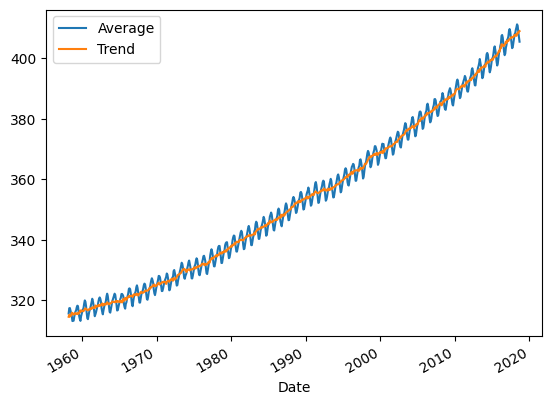

In [7]:
df = df.dropna()
df = df[["Average","Trend"]]
df.plot()

A dataframe with a datetimeindex can be used to create a dfs0 with a non-equidistant time axis by first converting it to a mikeio.Dataset.

In [8]:
ds = mikeio.from_pandas(df)
ds

<mikeio.Dataset>
dims: (time:720)
time: 1958-03-01 00:00:00 - 2018-09-01 00:00:00 (720 non-equidistant records)
geometry: GeometryUndefined()
items:
  0:  Average <Undefined> (undefined)
  1:  Trend <Undefined> (undefined)

And then write to a dfs0 file:

In [9]:
ds.to_dfs("mauna_loa_co2.dfs0")

To get a equidistant time axis first interpolate to regularly spaced values, in this case daily.

*The code for this can be written in many ways, below is an example, where we avoid temporary variables.*

In [14]:
(
df.resample("D") # resample to daily
  .interpolate() # interpolate linearly
  .pipe(mikeio.from_pandas) # convert to mikeio.Dataset
  .to_dfs("mauna_loa_co2_daily.dfs0") # save to dfs0
 )

# Read a timeseries

In [11]:
res = mikeio.read("test.dfs0")
res

<mikeio.Dataset>
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
items:
  0:  Zeros <Water Level> (meter)
  1:  Ones <Discharge> (meter pow 3 per sec)

In [12]:
res.time

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:00:00',
               '2000-01-01 02:00:00', '2000-01-01 03:00:00',
               '2000-01-01 04:00:00', '2000-01-01 05:00:00',
               '2000-01-01 06:00:00', '2000-01-01 07:00:00',
               '2000-01-01 08:00:00', '2000-01-01 09:00:00'],
              dtype='datetime64[ns]', freq=None)

In [13]:
res.to_numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## Or as a Pandas dataframe

A mikeio.Dataset ds is converted to a pandas dataframe with ds.to_dataframe()

In [14]:
dfs0file = "../tests/testdata/da_diagnostic.dfs0"
df = mikeio.read(dfs0file).to_dataframe()
df.head()

,State 1Sign. Wave Height,State 2Sign. Wave Height,Mean StateSign. Wave Height,MeasurementSign. Wave Height
2017-10-27 00:00:00,1.749465,1.749465,1.749465,1.72
2017-10-27 00:10:00,1.811340,1.796895,1.807738,NaN
2017-10-27 00:20:00,1.863424,1.842759,1.853422,NaN
2017-10-27 00:30:00,1.922261,1.889839,1.897670,NaN
2017-10-27 00:40:00,1.972455,1.934886,1.935281,NaN


In [15]:
dfs0file = "../tests/testdata/random.dfs0"
df = mikeio.read(dfs0file).to_dataframe()
df.head()

,VarFun01,NotFun
2017-01-01 00:00:00,0.843547,0.640486
2017-01-01 05:00:00,0.093729,0.653257
2017-01-01 10:00:00,NaN,NaN
2017-01-01 15:00:00,0.305065,0.214208
2017-01-01 20:00:00,0.900190,0.999157


## Create a timeseries with non-equidistant data

In [16]:
d1 = np.random.uniform(low=0.0, high=5.0, size=5)
time = pd.DatetimeIndex(["2000-1-1", "2000-1-8", "2000-1-10", "2000-2-22", "2000-11-29"])
da = mikeio.DataArray(d1, time=time, item=ItemInfo("Random"))
da

<mikeio.DataArray>
name: Random
dims: (time:5)
time: 2000-01-01 00:00:00 - 2000-11-29 00:00:00 (5 non-equidistant records)
values: [1.646, 1.234, ..., 2.629]

In [17]:
da.is_equidistant

False

In [18]:
da.to_dfs("neq.dfs0", title="Non equidistant")

## Create a timeseries with accumulated timestep

## Find correct eum units

In [19]:
EUMType.search("prec")

[Correction of precipitation,
 Precipitation correction,
 Precipitation,
 Specific Precipitation,
 Precipitation Rate]

In [20]:
EUMType.Precipitation_Rate.units

[mm per day,
 mm per hour,
 cm per hour,
 meter per sec,
 meter per day,
 feet per day,
 inch per hour,
 inch per min,
 inch per day,
 mm per year]

In [21]:
from mikecore.DfsFile import DataValueType

n= 1000
time = pd.date_range("2017-01-01 00:00", freq='H', periods=n)

# use default name and unit based on type
item = ItemInfo(EUMType.Water_Level, data_value_type=DataValueType.Instantaneous)
da1 = mikeio.DataArray(data=np.random.random([n]), time=time, item=item)

# use a custom name
item = ItemInfo("Nedbør", EUMType.Precipitation_Rate, data_value_type=DataValueType.Accumulated)
da2 = mikeio.DataArray(data=np.random.random([n]), time=time, item=item)

ds = mikeio.Dataset([da1, da2])
ds.to_dfs('accumulated.dfs0')

In [22]:
ds = mikeio.read("accumulated.dfs0")
ds

<mikeio.Dataset>
dims: (time:1000)
time: 2017-01-01 00:00:00 - 2017-02-11 15:00:00 (1000 records)
items:
  0:  Water Level <Water Level> (meter)
  1:  Nedbør <Precipitation Rate> (mm per day) - 1

# Modify an existing timeseries

In [23]:
ds = mikeio.read("test.dfs0")
ds

<mikeio.Dataset>
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
items:
  0:  Zeros <Water Level> (meter)
  1:  Ones <Discharge> (meter pow 3 per sec)

In [24]:
ds['Ones']

<mikeio.DataArray>
name: Ones
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
values: [1, 1, ..., 1]

Modify the data in some way...

In [25]:
ds['Ones'] = ds['Ones']*np.pi
ds['Ones'].values

array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265])

In [26]:
ds.to_dfs("modified.dfs0")

In [27]:
res = mikeio.read("modified.dfs0")
res['Ones']

<mikeio.DataArray>
name: Ones
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
values: [3.142, 3.142, ..., 3.142]

The second item is not modified.

In [28]:
res['Zeros']

<mikeio.DataArray>
name: Zeros
dims: (time:10)
time: 2000-01-01 00:00:00 - 2000-01-01 09:00:00 (10 records)
values: [0, 0, ..., 0]

## Convert units

Read a file with waterlevel i meters.

In [29]:
filename = "../tests/testdata/waterlevel_viken.dfs0"
# filename = r"C:\Program Files (x86)\DHI\MIKE Zero\2021\Examples\MIKE_21\FlowModel_FM\HD\Oresund\Data\1993\Boundary_Conditions\waterlevel_viken.dfs0"
ds = mikeio.read(filename)
ds

<mikeio.Dataset>
dims: (time:577)
time: 1993-12-02 00:00:00 - 1993-12-14 00:00:00 (577 records)
items:
  0:  ST 2: WL (m) <Water Level> (meter)

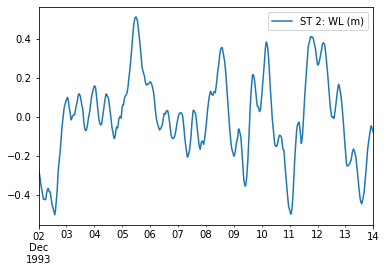

In [30]:
ds.plot()

The aim is to convert this timeseries to feet (1m = 3.3 ft)

In [31]:
ds[0] = ds[0]*3.3

Which units are acceptable?

In [32]:
ds.items[0].type.units

[meter,
 kilometer,
 centimeter,
 millimeter,
 feet,
 feet US,
 inch,
 inch US,
 mile,
 mile US,
 yard,
 yard US]

In [33]:
ds[0].item = ItemInfo("Viken", ds[0].item.type, EUMUnit.feet)

In [34]:
ds.to_dfs("wl_feet.dfs0")

![WL](https://github.com/DHI/mikeio/raw/main/images/wl_feet.png)

## Extrapolation

<AxesSubplot:>

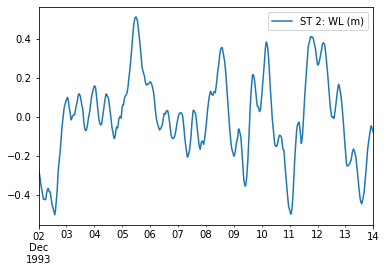

In [35]:
# filename = r"C:\Program Files (x86)\DHI\MIKE Zero\2021\Examples\MIKE_21\FlowModel_FM\HD\Oresund\Data\1993\Boundary_Conditions\waterlevel_viken.dfs0"
filename = "../tests/testdata/waterlevel_viken.dfs0"
ds = mikeio.read(filename)
df = ds.to_dataframe()
df.plot()

<AxesSubplot:>

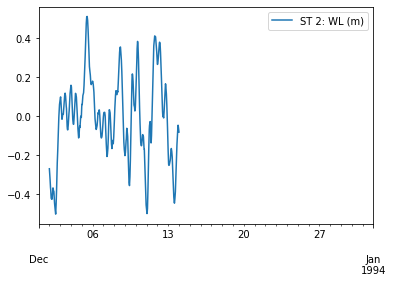

In [36]:
rng = pd.date_range("1993-12-1","1994-1-1",freq='30t')
ix = pd.DatetimeIndex(rng)
dfr = df.reindex(ix)
dfr.plot()

Replace NaN with constant extrapolation (forward fill + back fill).

<AxesSubplot:>

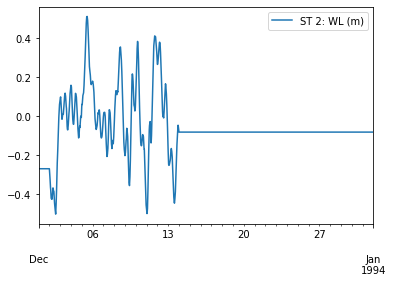

In [37]:
dfr = dfr.ffill().bfill()
dfr.plot()

In [38]:
dfr.to_dfs0("Viken_extrapolated.dfs0", 
            items=ds.items, 
            title="Caution extrapolated data!"
            )

## Clean up

In [39]:
import os

os.remove("test.dfs0")
os.remove("modified.dfs0")
os.remove("neq.dfs0")
os.remove("accumulated.dfs0")
os.remove("wl_feet.dfs0")
os.remove("mauna_loa_co2_eq_1hr.dfs0")
os.remove("mauna_loa_co2.dfs0")
os.remove("Viken_extrapolated.dfs0")